In [1]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
algo = "reverse_hybrid"
# algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [3]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

## Analysis

In [4]:
# function that print value counts of OS_STATUS and FFS_STATUS for each community
def print_status_counts(df, groupby='communityId'):
    df['FFS_STATUS'] = df['FFS_STATUS'].map(lambda x: int(x[0]))
    df['OS_STATUS'] = df['OS_STATUS'].map(lambda x: int(x[0]))
    print("\n🔍 OS_STATUS counts per community:")
    os_counts = df.groupby(groupby)['OS_STATUS'].value_counts().unstack(fill_value=0)
    print(os_counts)

    print("\n🔍 FFS_STATUS counts per community:")
    ffs_counts = df.groupby(groupby)['FFS_STATUS'].value_counts().unstack(fill_value=0)
    print(ffs_counts)

print_status_counts(merged_df)


🔍 OS_STATUS counts per community:
OS_STATUS      0    1
communityId          
0              0  156
1              0   50
2              0   80
3             29    0
4             37    0
5            117    0
6            104    0
7            110    0
8            231    0
9            148    0

🔍 FFS_STATUS counts per community:
FFS_STATUS     0    1
communityId          
0              0  156
1              0   50
2              0   80
3              0   29
4              0   37
5              0  117
6              0  104
7              0  110
8            224    7
9            148    0


communityId
0    156
1     50
2     80
3     29
4     37
5    117
6    104
7    110
8    231
9    148
Name: count, dtype: int64

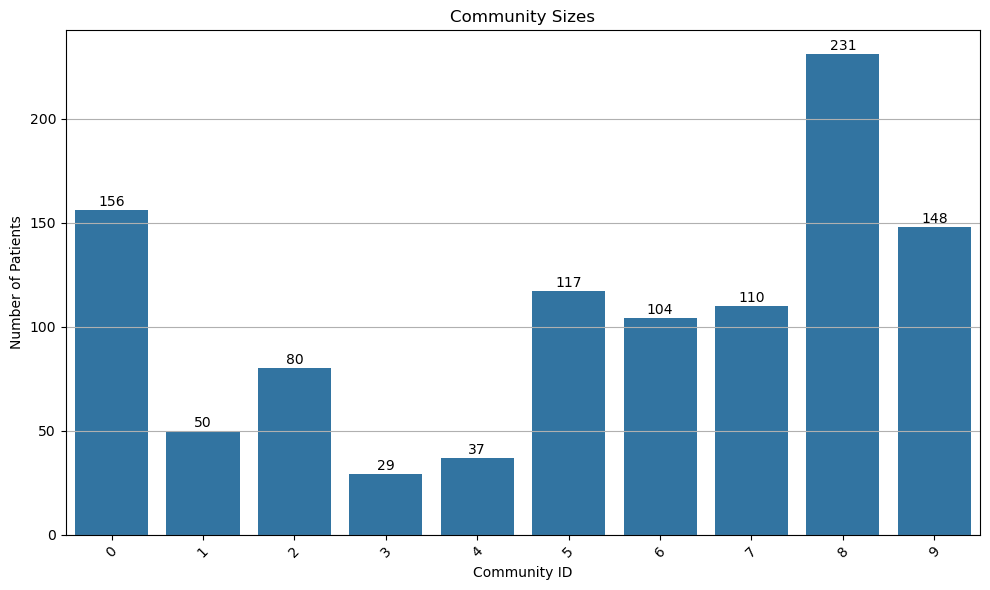

In [5]:
# plot community sizes
def plot_community_sizes(community_df):
    community_counts = community_df['communityId'].value_counts().sort_index()
    display(community_counts)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=community_counts.index, y=community_counts.values)
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    # annotate count on bars
    for i, count in enumerate(community_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_community_sizes(community_df)

In [6]:
from collections import defaultdict

def print_overlapping_nodes(community_df):
    """
    Prints patientIds that belong to multiple communities and their memberships.
    """
    patient_to_comms = defaultdict(set)
    for _, row in community_df.iterrows():
        patient_to_comms[row['patientId']].add(row['communityId'])
    overlapping = {pid: list(comms) for pid, comms in patient_to_comms.items() if len(comms) > 1}
    print(f"Number of overlapping patients: {len(overlapping)}")
    if overlapping:
        print("Overlapping patients and their community memberships:")
        for pid, comms in overlapping.items():
            print(f"  PatientId: {pid} -> Communities: {sorted(comms)}")
    else:
        print("No overlapping patients found.")

# Call the function
print_overlapping_nodes(community_df)

Number of overlapping patients: 54
Overlapping patients and their community memberships:
  PatientId: P-CRC-0004 -> Communities: [3, 5]
  PatientId: P-DFCI-5115 -> Communities: [3, 6]
  PatientId: P-SCLL-0031 -> Communities: [3, 6]
  PatientId: P-SCLL-0054 -> Communities: [3, 6]
  PatientId: P-DFCI-5143 -> Communities: [3, 6]
  PatientId: P-DFCI-5049 -> Communities: [3, 6]
  PatientId: P-DFCI-5066 -> Communities: [3, 6]
  PatientId: P-CRC-0008 -> Communities: [3, 6]
  PatientId: P-CRC-0014 -> Communities: [3, 6]
  PatientId: P-CRC-0013 -> Communities: [3, 6]
  PatientId: P-NHLBI-0075 -> Communities: [3, 6]
  PatientId: P-SCLL-0020 -> Communities: [3, 5]
  PatientId: P-DFCI-5095 -> Communities: [4, 6]
  PatientId: P-DFCI-5207 -> Communities: [4, 6]
  PatientId: P-DFCI-5068 -> Communities: [4, 6]
  PatientId: P-CRC-0012 -> Communities: [4, 6]
  PatientId: P-DFCI-5139 -> Communities: [4, 6]
  PatientId: P-DFCI-5154 -> Communities: [4, 6]
  PatientId: P-NHLBI-0057 -> Communities: [4, 6]
  

In [7]:
# 📌 SECTION 4: COMMUNITY DEMOGRAPHIC ANALYSIS
def demographic_summary(df, groupby='communityId'):
    print("🔍 Age, Sex distribution per community:\n")
    print(df.groupby(groupby)['AGE_SAMPLING'].describe())
    print("\n🔹 Sex distribution:\n")
    print(pd.crosstab(df[groupby], df['SEX'], normalize='index'))

    sns.boxplot(data=df, x=groupby, y='AGE_SAMPLING')
    plt.title("Age Distribution per Community")
    plt.show()

    sns.countplot(data=df, x=groupby, hue='SEX')
    plt.title("Sex Distribution per Community")
    plt.show()

🔍 Age, Sex distribution per community:

             count       mean        std   min    25%   50%    75%   max
communityId                                                             
0            156.0  67.826923  11.966169  35.0  60.75  67.0  77.00  94.0
1             50.0  62.840000  11.660784  40.0  53.00  64.0  72.00  84.0
2             80.0  65.250000  10.732065  44.0  58.00  65.0  73.00  89.0
3             29.0  58.068966   9.746542  37.0  51.00  57.0  65.00  82.0
4             37.0  62.000000   9.524821  39.0  56.00  62.0  67.00  84.0
5            117.0  60.666667  10.850870  19.0  55.00  62.0  68.00  82.0
6            104.0  60.692308  11.136468  34.0  53.75  62.0  67.25  84.0
7            110.0  62.054545  10.336394  38.0  54.25  63.0  69.00  86.0
8            231.0  63.696970  10.973642  36.0  57.00  64.0  71.50  89.0
9            148.0  61.391892  12.030367  31.0  52.75  62.0  69.25  92.0

🔹 Sex distribution:

SEX            Female      Male
communityId                   

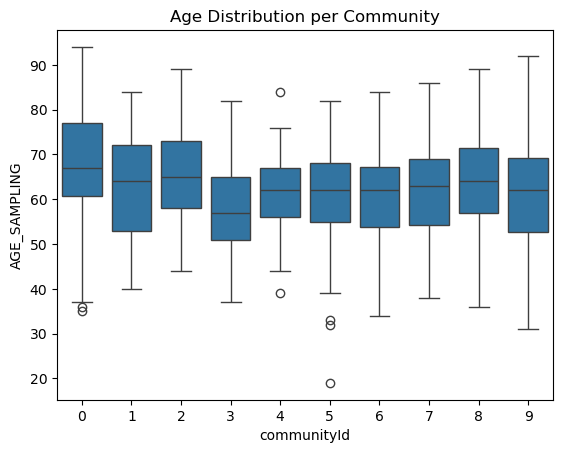

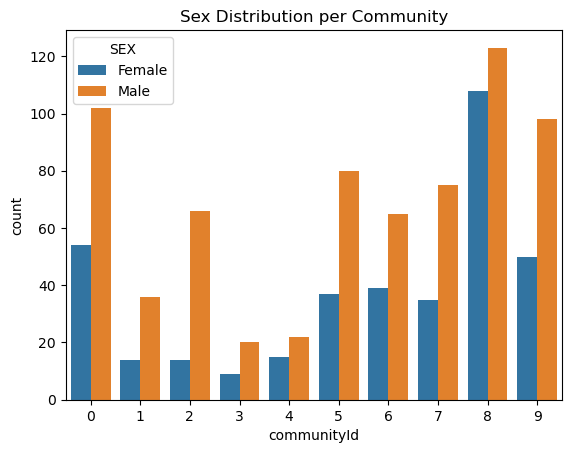

In [8]:
demographic_summary(merged_df)

In [9]:
# 📌 SECTION 5: CLINICAL ATTRIBUTE ANALYSIS
def clinical_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(pd.crosstab(df[groupby], df[feat], normalize='index'))

        sns.countplot(data=df, x=groupby, hue=feat)
        plt.title(f"{feat} per Community")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE     i-CLL     m-CLL     n-CLL  unclassified
communityId                                            
0            0.121795  0.198718  0.589744      0.089744
1            0.100000  0.160000  0.600000      0.140000
2            0.062500  0.312500  0.550000      0.075000
3            0.103448  0.379310  0.344828      0.172414
4            0.108108  0.189189  0.243243      0.459459
5            0.170940  0.196581  0.555556      0.076923
6            0.153846  0.288462  0.307692      0.250000
7            0.136364  0.218182  0.518182      0.127273
8            0.173160  0.601732  0.099567      0.125541
9            0.128378  0.405405  0.283784      0.182432


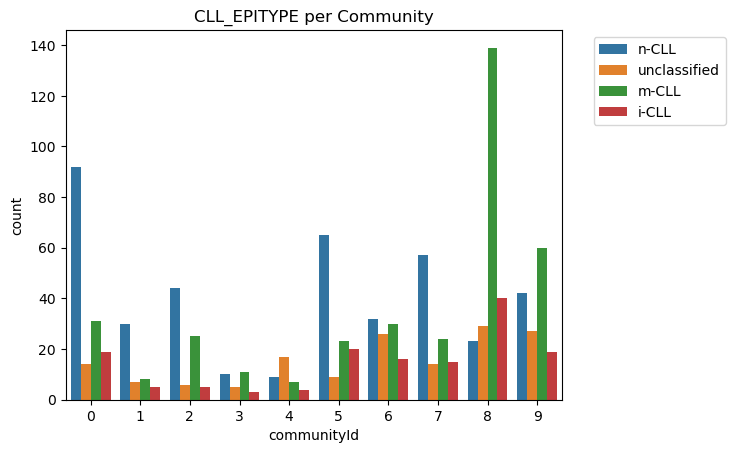


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL
communityId                                
0                        0.441176  0.558824
1                        0.564103  0.435897
2                        0.500000  0.500000
3                        0.720000  0.280000
4                        0.694444  0.305556
5                        0.548077  0.451923
6                        0.597826  0.402174
7                        0.515152  0.484848
8                        0.588235  0.411765
9                        0.495935  0.504065


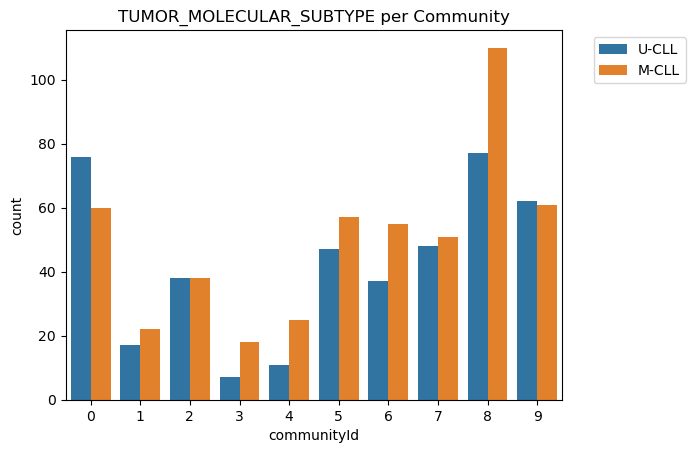


🔬 PRIOR_TREATMENT_CATEGORY distribution per community:

PRIOR_TREATMENT_CATEGORY  Ab + no Chemo  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
communityId                                                                    
0                              0.000000    0.076923       0.051282  0.000000   
1                              0.020000    0.000000       0.020000  0.000000   
2                              0.000000    0.037500       0.025000  0.000000   
3                              0.000000    0.000000       0.034483  0.000000   
4                              0.000000    0.000000       0.027027  0.000000   
5                              0.000000    0.025641       0.008547  0.000000   
6                              0.000000    0.000000       0.019231  0.000000   
7                              0.009091    0.081818       0.027273  0.009091   
8                              0.000000    0.012987       0.012987  0.000000   
9                              0.006757    0.047297       0.033

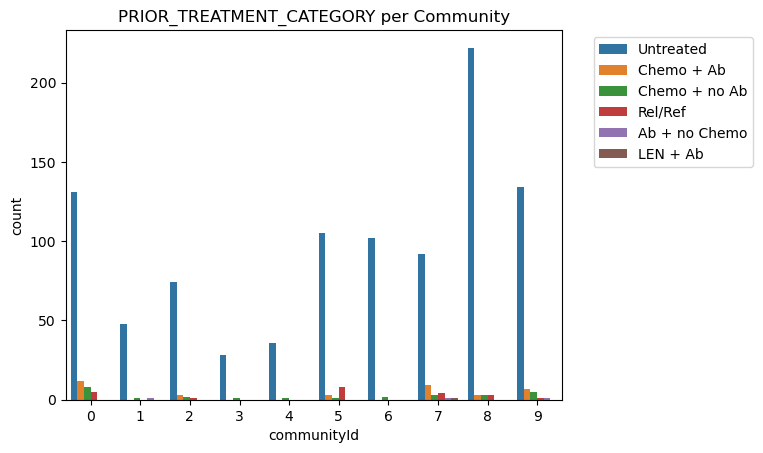


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + Ab  BCL2 + BTK  BCL2 + chemo  \
communityId                                                                    
0                              0.096774       0.00        0.00      0.016129   
1                              0.083333       0.00        0.00      0.000000   
2                              0.000000       0.00        0.00      0.000000   
3                              0.000000       0.00        0.00      0.000000   
4                              0.055556       0.00        0.00      0.000000   
5                              0.020000       0.02        0.02      0.000000   
6                              0.022727       0.00        0.00      0.000000   
7                              0.104167       0.00        0.00      0.020833   
8                              0.060606       0.00        0.00      0.000000   
9                              0.064516       0.00        0.00 

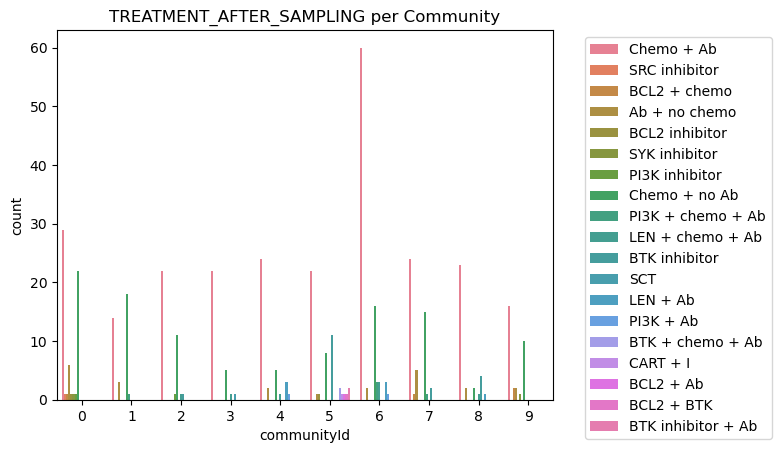

In [10]:
clinical_features = ['CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(merged_df, clinical_features)


🔬 IGLV3_21_R110 distribution per community:

IGLV3_21_R110        No       Yes
communityId                      
0              0.887417  0.112583
1              0.816327  0.183673
2              0.911392  0.088608
3              0.928571  0.071429
4              0.918919  0.081081
5              0.857143  0.142857
6              0.950495  0.049505
7              0.890909  0.109091
8              0.911894  0.088106
9              0.894366  0.105634


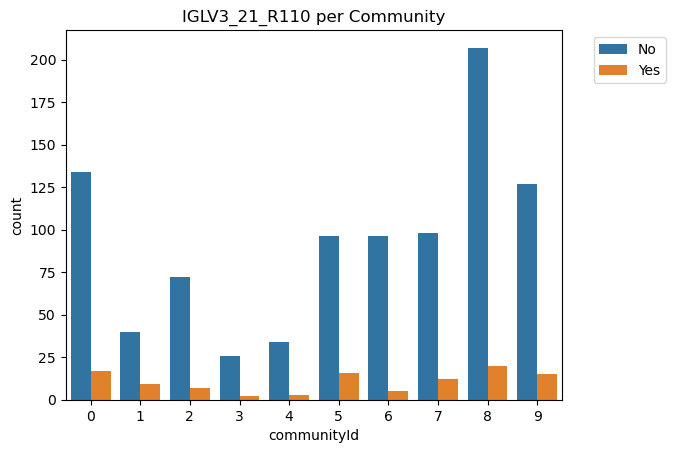


🔬 U1_STATUS distribution per community:

U1_STATUS         MUT        WT
communityId                    
0            0.024793  0.975207
1            0.026316  0.973684
2            0.045455  0.954545
3            0.080000  0.920000
4            0.000000  1.000000
5            0.029126  0.970874
6            0.023529  0.976471
7            0.060606  0.939394
8            0.035503  0.964497
9            0.032787  0.967213


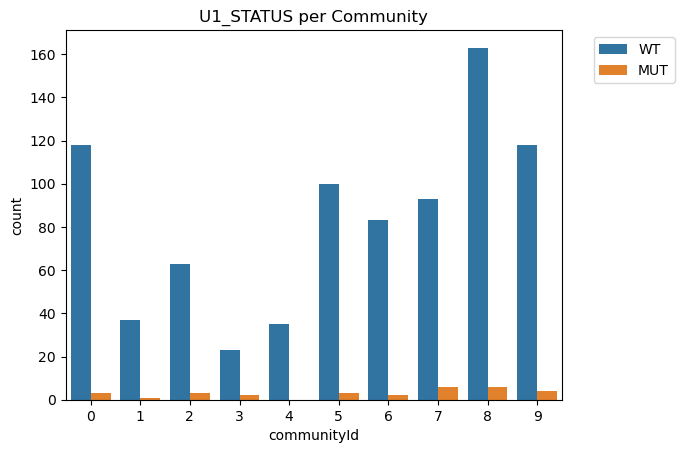


🔬 EXPRESSION_CLUSTER distribution per community:

EXPRESSION_CLUSTER         0  2258      EC-i     EC-m1     EC-m2     EC-m3  \
communityId                                                                  
0                   0.435897  0.00  0.038462  0.032051  0.051282  0.025641   
1                   0.340000  0.02  0.100000  0.000000  0.040000  0.000000   
2                   0.375000  0.00  0.075000  0.087500  0.037500  0.025000   
3                   0.344828  0.00  0.103448  0.068966  0.068966  0.068966   
4                   0.378378  0.00  0.135135  0.027027  0.054054  0.027027   
5                   0.529915  0.00  0.051282  0.059829  0.025641  0.017094   
6                   0.394231  0.00  0.144231  0.028846  0.057692  0.028846   
7                   0.490909  0.00  0.063636  0.036364  0.036364  0.000000   
8                   0.432900  0.00  0.021645  0.069264  0.051948  0.129870   
9                   0.445946  0.00  0.047297  0.054054  0.047297  0.067568   

EXPRESSION_C

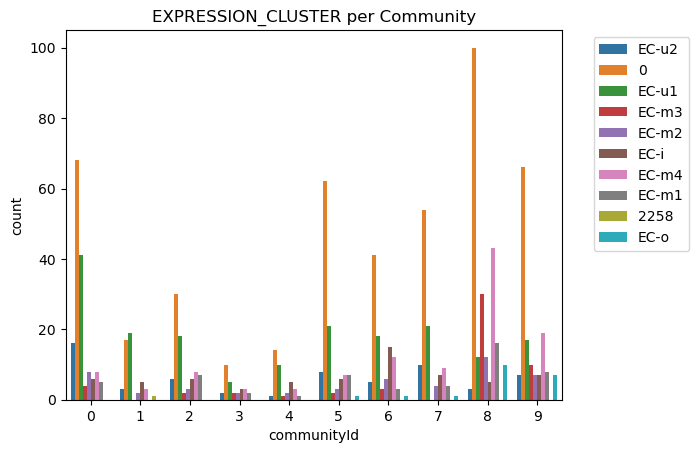


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated  unmutated
communityId                              
0                     0.316129   0.683871
1                     0.244898   0.755102
2                     0.423077   0.576923
3                     0.586207   0.413793
4                     0.432432   0.567568
5                     0.403509   0.596491
6                     0.500000   0.500000
7                     0.336449   0.663551
8                     0.850877   0.149123
9                     0.623288   0.376712


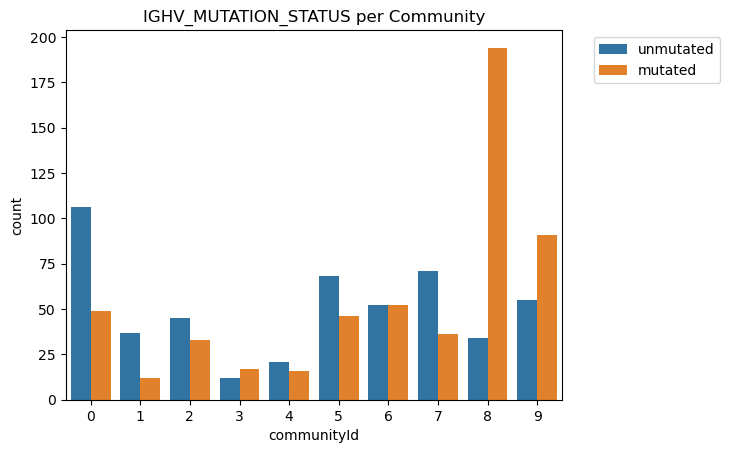

In [11]:
clinical_features = ['IGLV3_21_R110','U1_STATUS', 'EXPRESSION_CLUSTER', 'IGHV_MUTATION_STATUS']
clinical_summary(merged_df, clinical_features)


🔬 COHORT distribution per community:

COHORT           DFCI    GCLLSG      ICGC     MDACC     NHLBI      UCSD
communityId                                                            
0            0.115385  0.358974  0.435897  0.032051  0.051282  0.006410
1            0.040000  0.260000  0.680000  0.020000  0.000000  0.000000
2            0.075000  0.262500  0.500000  0.037500  0.050000  0.075000
3            0.310345  0.000000  0.379310  0.000000  0.034483  0.275862
4            0.594595  0.000000  0.243243  0.000000  0.108108  0.054054
5            0.059829  0.333333  0.316239  0.051282  0.222222  0.017094
6            0.307692  0.125000  0.413462  0.000000  0.086538  0.067308
7            0.145455  0.463636  0.245455  0.018182  0.127273  0.000000
8            0.233766  0.168831  0.562771  0.008658  0.017316  0.008658
9            0.216216  0.310811  0.432432  0.020270  0.020270  0.000000


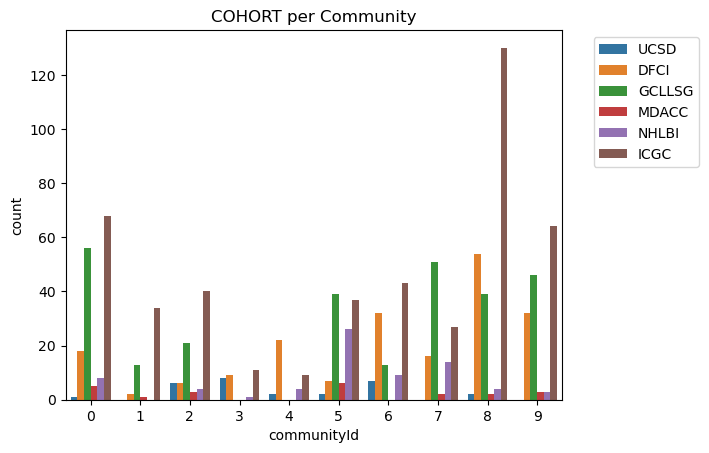


🔬 originId distribution per community:

originId            1         2         3         4         5         6  \
communityId                                                               
0            0.435897  0.006410  0.000000  0.012821  0.115385  0.358974   
1            0.680000  0.000000  0.020000  0.000000  0.020000  0.260000   
2            0.500000  0.075000  0.025000  0.012500  0.050000  0.262500   
3            0.379310  0.275862  0.000000  0.034483  0.310345  0.000000   
4            0.243243  0.054054  0.081081  0.108108  0.513514  0.000000   
5            0.316239  0.017094  0.008547  0.000000  0.051282  0.333333   
6            0.413462  0.067308  0.048077  0.076923  0.259615  0.125000   
7            0.245455  0.000000  0.009091  0.063636  0.136364  0.463636   
8            0.562771  0.008658  0.043290  0.000000  0.190476  0.168831   
9            0.432432  0.000000  0.027027  0.013514  0.189189  0.310811   

originId            8         9  
communityId             

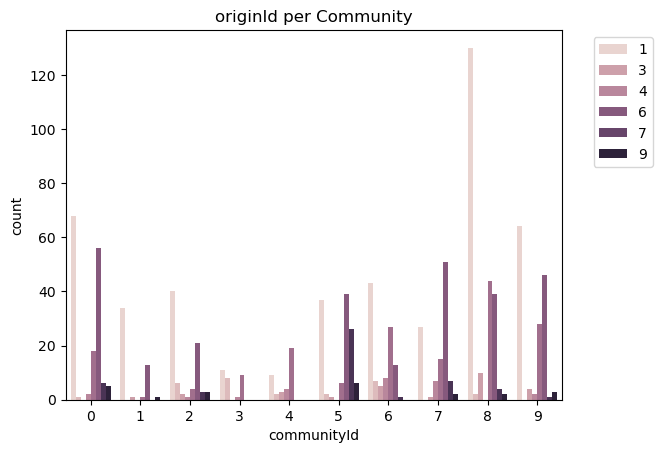


🔬 originType distribution per community:

originType   PUBLICATION     TRIAL
communityId                       
0               0.570513  0.429487
1               0.720000  0.280000
2               0.662500  0.337500
3               1.000000  0.000000
4               1.000000  0.000000
5               0.393162  0.606838
6               0.865385  0.134615
7               0.454545  0.545455
8               0.805195  0.194805
9               0.662162  0.337838


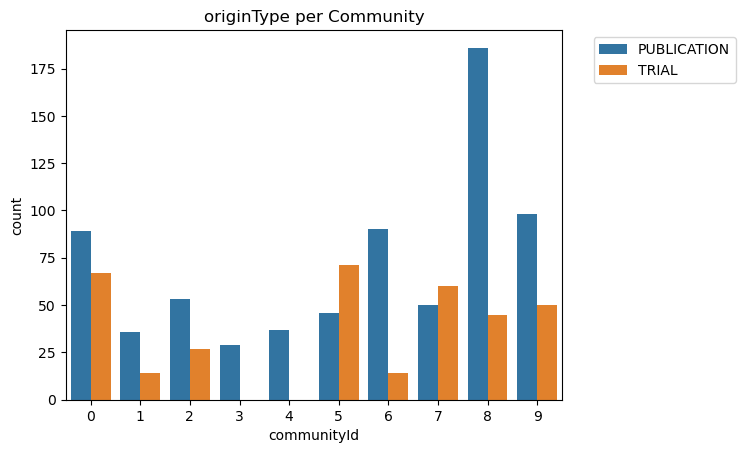

In [12]:
clinical_features = ['COHORT','originId', 'originType']
clinical_summary(merged_df, clinical_features)

In [13]:
# 📌 SECTION 5B: CLINICAL NUMERIC ATTRIBUTES
def clinical_numeric_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(df.groupby(groupby)[feat].describe())

        sns.boxplot(data=df, x=groupby, y=feat)
        plt.title(f"{feat} Distribution per Community")
        plt.show()


🔬 MUTATION_COUNT distribution per community:

             count       mean         std   min   25%   50%    75%    max
communityId                                                              
0            141.0  33.553191   26.479487   7.0  22.0  30.0  40.00  293.0
1             44.0  35.522727   26.628791   7.0  19.5  31.5  41.00  142.0
2             70.0  36.985714   42.829792  10.0  19.0  26.0  37.75  320.0
3             29.0  58.862069  115.139581   7.0  19.0  28.0  40.00  556.0
4             34.0  28.705882   17.719240   4.0  18.5  24.5  34.25   78.0
5            112.0  33.821429   34.630928   8.0  20.0  25.5  33.25  310.0
6             95.0  26.852632   13.586577   4.0  19.0  24.0  31.00   78.0
7            105.0  27.447619   15.545208   5.0  18.0  25.0  33.00  113.0
8            209.0  27.449761   25.799497   4.0  17.0  24.0  31.00  331.0
9            135.0  25.585185   21.138980   6.0  16.0  22.0  28.00  197.0


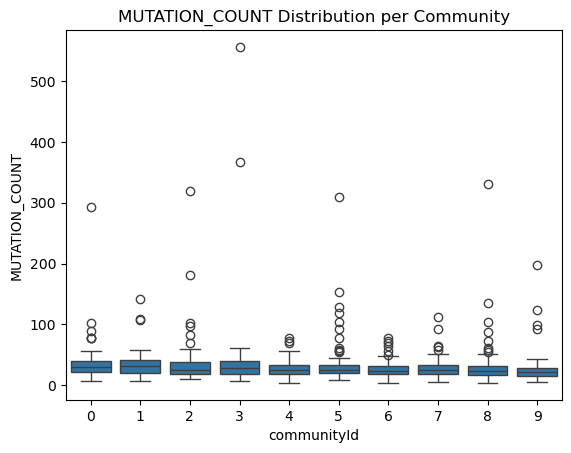


🔬 TMB_NONSYNONYMOUS distribution per community:

             count      mean       std       min       25%       50%  \
communityId                                                            
0            141.0  1.117494  0.883082  0.233333  0.733333  1.000000   
1             44.0  1.183333  0.887714  0.233333  0.650000  1.050000   
2             70.0  1.230952  1.428154  0.333333  0.633333  0.866667   
3             29.0  1.965517  3.849505  0.233333  0.633333  0.933333   
4             34.0  0.957843  0.590857  0.133333  0.616667  0.816667   
5            112.0  1.126786  1.154621  0.266667  0.666667  0.850000   
6             95.0  0.895088  0.453903  0.133333  0.633333  0.800000   
7            105.0  0.914921  0.518070  0.166667  0.600000  0.833333   
8            209.0  0.914673  0.860436  0.133333  0.566667  0.800000   
9            135.0  0.852346  0.703692  0.200000  0.533333  0.733333   

                  75%        max  
communityId                       
0            1.

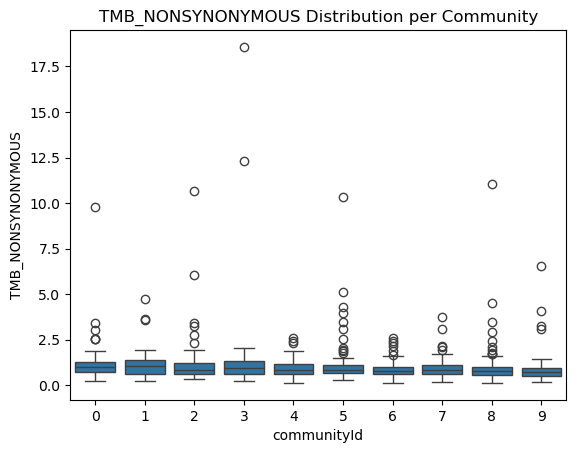


🔬 IGHV_IDENTITY_PERCENTAGE distribution per community:

             count       mean       std    min      25%     50%       75%  \
communityId                                                                 
0            155.0  97.954452  3.193532  87.85  96.3550  100.00  100.0000   
1             49.0  98.353878  2.989012  87.50  98.2600  100.00  100.0000   
2             78.0  97.197564  3.658857  87.88  93.7625  100.00  100.0000   
3             29.0  96.208966  3.628669  89.95  93.6800   96.60  100.0000   
4             37.0  97.532703  3.282528  88.89  96.5300   99.30  100.0000   
5            112.0  97.381161  3.767447  84.72  95.5875   99.66  100.0000   
6            104.0  96.793365  3.648195  84.91  94.9650   98.09  100.0000   
7            106.0  98.066038  2.942166  86.46  96.5550  100.00  100.0000   
8            228.0  94.755088  3.180652  85.26  92.3600   95.09   96.9025   
9            146.0  96.063151  3.602370  85.76  93.0775   96.53  100.0000   

               max

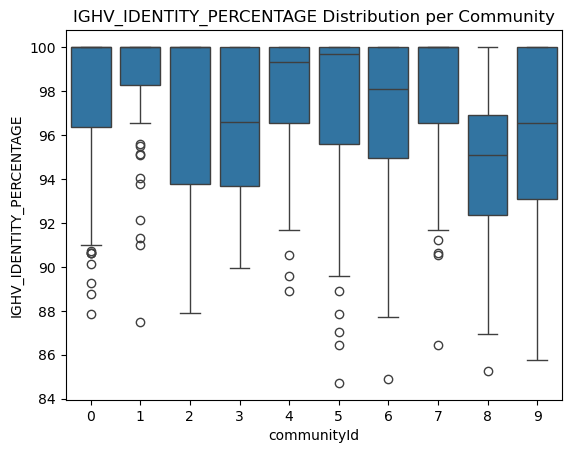

In [14]:
clinical_numeric_features = ['MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 'IGHV_IDENTITY_PERCENTAGE']
clinical_numeric_summary(merged_df, clinical_numeric_features)

In [15]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [16]:
# 📌 SECTION 6: MUTATION ENRICHMENT ANALYSIS (Patient-level)

def mutation_enrichment(mutation_annotated, community_df, top_n_genes=20):
    # For each community and gene, count unique patients with at least one mutation
    gene_patient_counts = mutation_annotated.groupby(['communityId', 'hugoGeneSymbol'])['patientId'].nunique().unstack(fill_value=0)
    # Find top N most mutated genes overall (by unique patient count)
    top_genes = gene_patient_counts.sum(axis=0).sort_values(ascending=False).head(top_n_genes).index
    gene_counts_top = gene_patient_counts[top_genes]
    # For each community, get total unique patients
    comm_patient_counts = mutation_annotated.groupby('communityId')['patientId'].nunique()
    gene_fraction = gene_counts_top.div(comm_patient_counts, axis=0)
    sns.heatmap(gene_fraction.T, cbar_kws={'label': 'Fraction of Patients'})
    plt.title(f"Top {top_n_genes} Gene Mutation Enrichment per Community (Patient-level)")
    plt.xlabel("Community")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

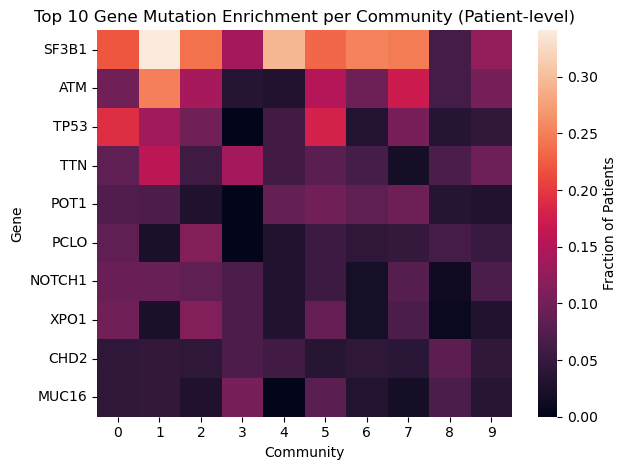

In [17]:
mutation_enrichment(mutation_annotated, community_df, top_n_genes=10)

In [18]:
# 📌 SECTION 6C: PLOT CATEGORICAL FEATURES (≤10 unique values, Patient-level)
def plot_small_categoricals(df, features, groupby='communityId'):
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for feat in features:
        if df[feat].nunique() <= 10:
            print(f"\n🔹 Distribution of '{feat}' across communities (fraction of patients):")
            # For each community and value, count unique patients
            ct = df.groupby([groupby, feat])['patientId'].nunique().unstack(fill_value=0)
            ct_frac = ct.div(comm_patient_counts, axis=0)
            display(ct_frac.style.format("{:.2%}"))
            ct_frac.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
            plt.title(f"{feat} Distribution by Community (Patient-level)")
            plt.ylabel("Fraction of Patients")
            plt.xlabel("Community")
            plt.legend(title=feat, bbox_to_anchor=(1.05, 1), loc='upper left')
            # annotate percentage on bars
            plt.tight_layout()
            plt.show()



🔹 Distribution of 'mutationType' across communities (fraction of patients):


mutationType,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Region,Splice_Site,Translation_Start_Site
communityId,,,,,,,,,,
0,55.32%,24.82%,17.73%,2.84%,100.00%,78.01%,2.84%,28.37%,56.03%,4.26%
1,63.64%,20.45%,18.18%,0.00%,100.00%,79.55%,4.55%,38.64%,34.09%,4.55%
2,45.07%,21.13%,19.72%,4.23%,100.00%,67.61%,4.23%,32.39%,42.25%,8.45%
3,37.93%,24.14%,13.79%,0.00%,100.00%,79.31%,6.90%,37.93%,48.28%,0.00%
4,38.24%,17.65%,17.65%,0.00%,100.00%,67.65%,5.88%,20.59%,44.12%,0.00%
5,48.21%,18.75%,20.54%,0.89%,100.00%,76.79%,3.57%,18.75%,45.54%,1.79%
6,41.05%,21.05%,13.68%,0.00%,100.00%,71.58%,5.26%,24.21%,42.11%,2.11%
7,50.48%,20.95%,18.10%,1.90%,100.00%,71.43%,2.86%,20.00%,45.71%,2.86%
8,40.19%,14.83%,14.35%,1.44%,100.00%,68.90%,4.31%,21.05%,40.19%,2.87%


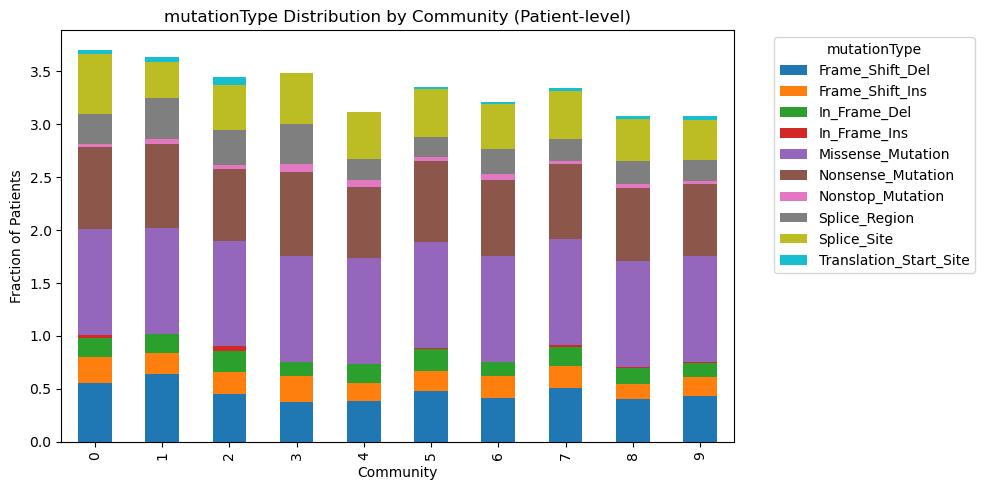


🔹 Distribution of 'variantType' across communities (fraction of patients):


variantType,DEL,INS,SNP
communityId,,,
0,65.96%,28.37%,100.00%
1,65.91%,20.45%,100.00%
2,59.15%,23.94%,100.00%
3,44.83%,27.59%,100.00%
4,47.06%,17.65%,100.00%
5,57.14%,21.43%,100.00%
6,46.32%,22.11%,100.00%
7,62.86%,26.67%,100.00%
8,49.28%,17.22%,100.00%


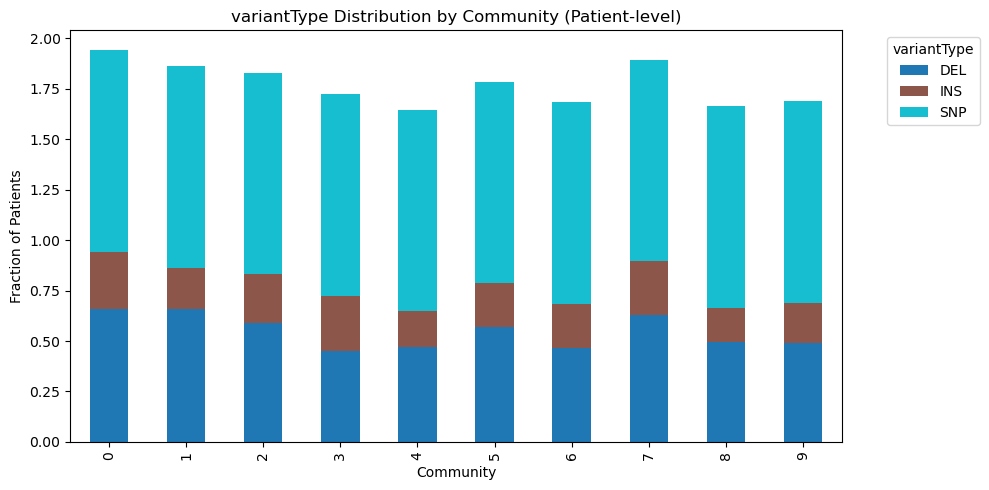

In [19]:
small_categorical_features = ['mutationType', 'variantType']
plot_small_categoricals(mutation_annotated, small_categorical_features)

In [20]:
# 📌 SECTION 6D: TOP-5 HIGH CARDINALITY CATEGORICAL FEATURES (Patient-level Percentages)
def top_values_by_community(df, col, groupby='communityId', top_n=5):
    print(f"\n🔎 Top {top_n} values of '{col}' per community (percentage of patients with at least one {col}):")
    
    rows = []
    plot_data = []
    # For each community, get total unique patients
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for cid, sub in df.groupby(groupby):
        total_patients = comm_patient_counts[cid]
        # For each value, count unique patients with at least one occurrence
        val_patient_counts = sub.groupby(col)['patientId'].nunique().sort_values(ascending=False).head(top_n)
        for val, n_patients in val_patient_counts.items():
            pct = 100 * n_patients / total_patients if total_patients > 0 else 0
            rows.append({'Community': cid, col: val, 'Percentage': round(pct, 2)})
            plot_data.append({'Community': cid, col: val, 'Percentage': pct})
    
    # Table: Top N per community, percentage of patients
    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index='Community', columns=col, values='Percentage').fillna(0))
    
    # Plot: Stacked bar, only top N per community, percentage of patients
    plot_df = pd.DataFrame(plot_data)
    pivot = plot_df.pivot(index='Community', columns=col, values='Percentage').fillna(0)
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    plt.title(f"Top {top_n} '{col}' values by Community (Percent of Patients)")
    plt.ylabel("% of Patients in Community")
    plt.xlabel("Community")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Annotate percentages on bars
    for i, (idx, row) in enumerate(pivot.iterrows()):
        cumm = 0
        for j, val in enumerate(row):
            if val > 0:
                plt.text(i, cumm + val/2, f"{val:.1f}%", ha='center', va='center', fontsize=9)
                cumm += val
    plt.show()


🔎 Top 5 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,AHNAK,ATM,ATRX,BIRC3,CHD2,CSMD3,DNAH17,IGLL5,KRAS,MUC16,...,NOTCH1,PCLO,POT1,SETDB1,SF3B1,TP53,TTN,XPO1,ZFHX4,ZNF292
Community,,,,,,,,,,,,,,,,,,,,,
0,0.00,9.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,9.22,0.00,0.00,0.00,21.99,19.15,0.00,9.93,0.00,0.00
1,0.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,34.09,13.64,15.91,0.00,0.00,9.09
2,0.00,14.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,11.27,0.00,0.00,23.94,9.86,0.00,11.27,0.00,0.00
3,17.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.79,0.0,...,0.00,0.00,0.00,13.79,13.79,0.00,13.79,0.00,0.00,0.00
4,0.00,0.00,8.82,0.00,0.00,11.76,8.82,8.82,0.00,0.0,...,0.00,0.00,0.00,0.00,29.41,0.00,0.00,0.00,0.00,0.00
5,0.00,15.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,9.82,0.00,23.21,17.86,0.00,8.93,0.00,0.00
6,0.00,9.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,8.42,0.00,25.26,0.00,0.00,0.00,6.32,0.00
7,0.00,17.14,0.00,8.57,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,9.52,0.00,24.76,10.48,0.00,0.00,0.00,0.00
8,0.00,6.22,0.00,0.00,8.13,0.00,0.00,0.00,0.00,6.7,...,0.00,0.00,0.00,0.00,6.22,0.00,6.70,0.00,0.00,0.00


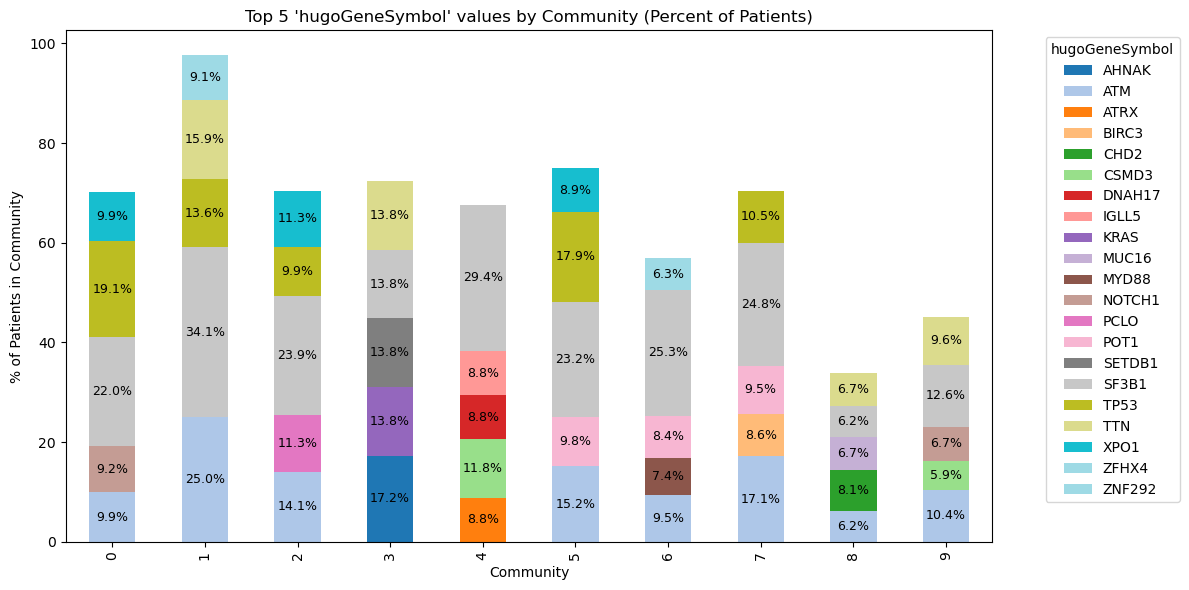


🔎 Top 5 values of 'proteinChange' per community (percentage of patients with at least one proteinChange):


proteinChange,A199V,A278T,A361V,A391V,D622N,E356K,E571K,F266L,G109R,G13D,...,L265P,L65P,M1?,P143T,P2514Rfs*4,Q61R,T7K,X102_splice,X290_splice,X66_splice
Community,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,4.96,7.09,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,7.09,0.00,0.00,0.00,0.00,0.0
1,4.55,0.00,4.55,0.00,0.00,0.00,0.00,0.00,4.55,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,4.55,0.0
2,0.00,0.00,0.00,4.23,0.00,0.00,5.63,0.00,0.00,0.00,...,0.00,0.00,8.45,0.0,7.04,0.00,0.00,0.00,0.00,0.0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,6.9,0.00,0.00,0.00,10.34,0.00,6.9
4,0.00,0.00,0.00,0.00,5.88,0.00,0.00,5.88,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,5.88,0.00,0.00,0.0
5,0.00,2.68,0.00,0.00,0.00,0.00,4.46,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,2.68,0.00,0.00,0.00,0.0
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.26,3.16,...,5.26,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.76,0.00,...,0.00,0.00,0.00,0.0,5.71,0.00,0.00,0.00,0.00,0.0
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.83,2.39,2.87,0.0,0.00,0.00,0.00,0.00,0.00,0.0


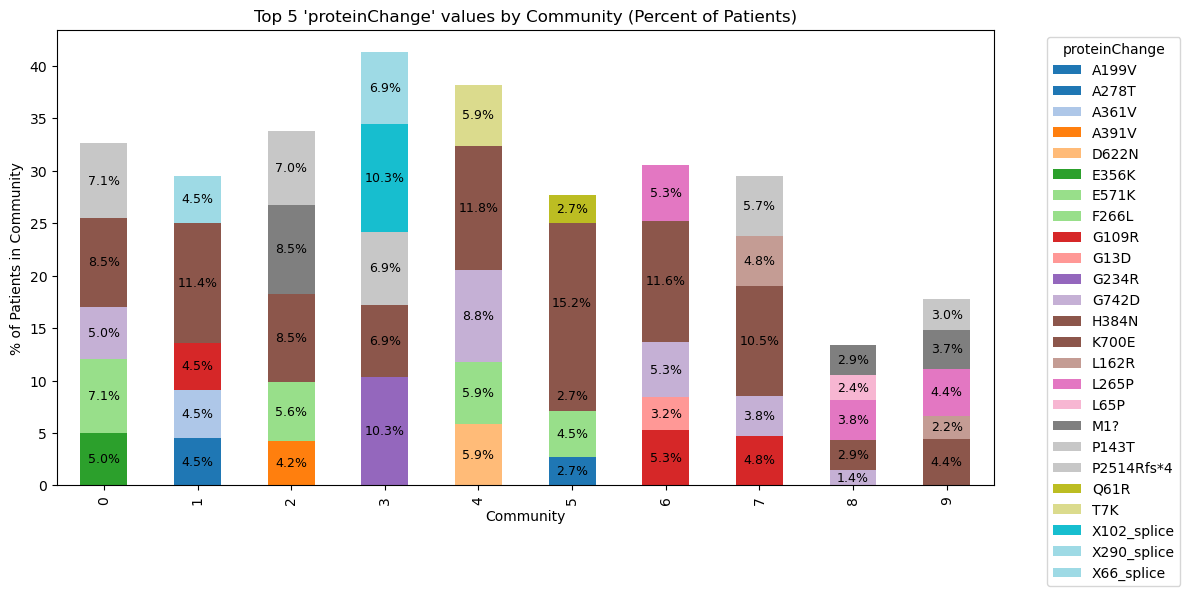


🔎 Top 5 values of 'referenceAllele' per community (percentage of patients with at least one referenceAllele):


referenceAllele,-,A,C,G,T
Community,,,,,
0,28.37,97.87,100.00,100.00,97.87
1,20.45,95.45,100.00,100.00,90.91
2,23.94,91.55,100.00,100.00,92.96
3,27.59,93.10,96.55,100.00,100.00
4,17.65,97.06,100.00,97.06,97.06
5,21.43,96.43,100.00,100.00,94.64
6,22.11,97.89,100.00,98.95,96.84
7,26.67,93.33,100.00,99.05,92.38
8,17.22,96.17,99.52,100.00,93.78


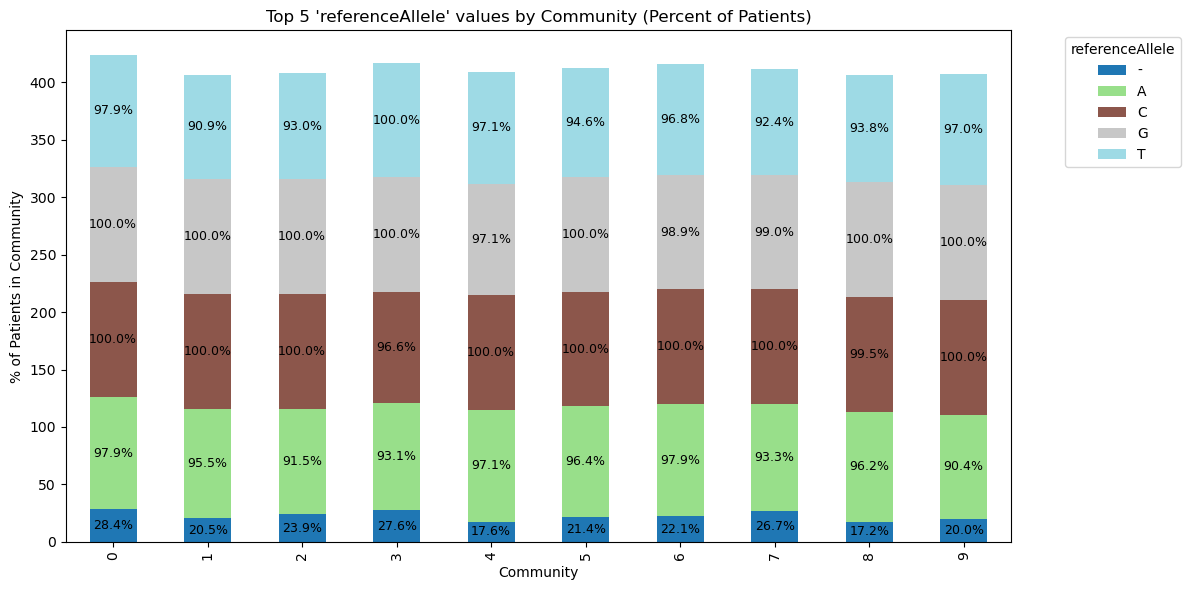


🔎 Top 5 values of 'variantAllele' per community (percentage of patients with at least one variantAllele):


variantAllele,-,A,C,G,T
Community,,,,,
0,65.96,100.00,96.45,95.74,100.00
1,65.91,100.00,88.64,95.45,100.00
2,59.15,100.00,94.37,94.37,100.00
3,44.83,100.00,100.00,100.00,100.00
4,47.06,100.00,100.00,91.18,100.00
5,57.14,100.00,92.86,89.29,100.00
6,46.32,100.00,94.74,95.79,100.00
7,62.86,100.00,95.24,92.38,100.00
8,49.28,99.52,97.61,93.78,99.04


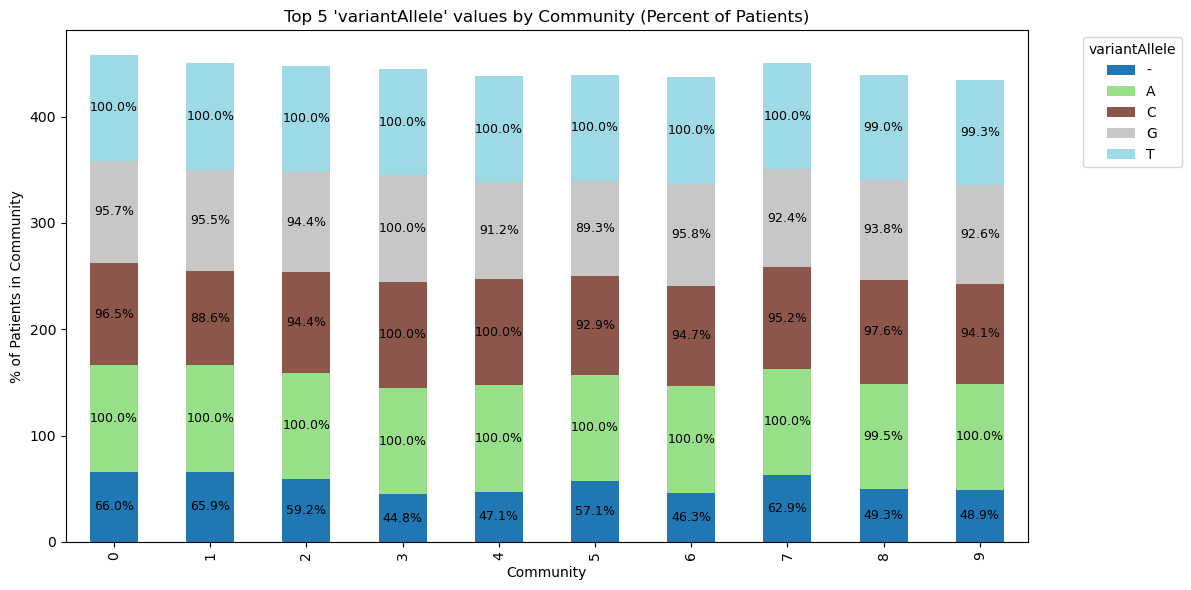

In [21]:
columns_to_analyze = [
    'hugoGeneSymbol', 'proteinChange', 'referenceAllele', 'variantAllele'
    # Add more columns as needed
]
for col in columns_to_analyze:
    top_values_by_community(mutation_annotated, col)  # Patient-level analysis

In [22]:
# 📌 SECTION 6E: NUMERICAL SUMMARY (tumorAltCount, tumorRefCount)
def numeric_distribution_by_community(df, numeric_cols, groupby='communityId'):
    for col in numeric_cols:
        print(f"\n📊 Summary statistics for {col}:")
        display(df.groupby(groupby)[col].describe())

        sns.boxplot(data=df, x=groupby, y=col)
        plt.title(f"{col} Distribution by Community")
        plt.tight_layout()
        plt.show()


📊 Summary statistics for tumorAltCount:


,count,mean,std,min,25%,50%,75%,max
communityId,,,,,,,,
0,4661.0,19.628620,31.071944,2.0,4.0,7.0,23.0,731.0
1,1545.0,14.003236,21.069448,2.0,4.0,5.0,15.0,208.0
2,2575.0,16.784078,25.725253,2.0,4.0,6.0,19.0,276.0
3,1646.0,12.349332,27.258106,0.0,3.0,5.0,8.0,417.0
4,961.0,18.159209,26.060399,2.0,4.0,7.0,23.0,316.0
5,3731.0,19.140445,30.303480,2.0,4.0,7.0,21.0,511.0
6,2511.0,18.526483,27.004721,0.0,4.0,7.0,23.0,417.0
7,2828.0,21.931400,30.489165,2.0,4.0,10.0,27.0,349.0
8,5655.0,18.191335,27.658272,2.0,4.0,7.0,22.0,452.0


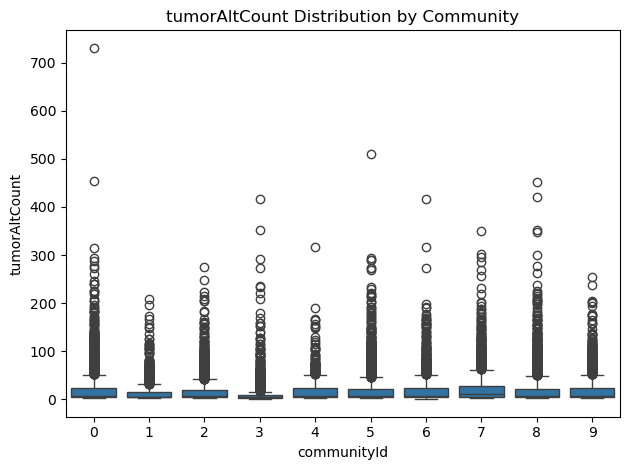


📊 Summary statistics for tumorRefCount:


,count,mean,std,min,25%,50%,75%,max
communityId,,,,,,,,
0,4661.0,92.104055,101.372043,0.0,33.0,63.0,113.0,1856.0
1,1545.0,88.951456,85.408055,0.0,33.0,65.0,115.0,751.0
2,2575.0,112.081942,105.926302,0.0,38.5,78.0,156.0,1009.0
3,1646.0,130.826245,130.593390,0.0,49.0,92.0,162.0,1067.0
4,961.0,92.696150,94.873915,0.0,35.0,64.0,114.0,956.0
5,3731.0,113.142321,110.471004,0.0,42.0,84.0,148.0,1525.0
6,2511.0,86.084030,89.354438,0.0,32.5,61.0,107.5,977.0
7,2828.0,109.494342,122.250609,0.0,38.0,74.5,140.0,1331.0
8,5655.0,94.552608,126.674057,0.0,32.0,61.0,112.0,2883.0


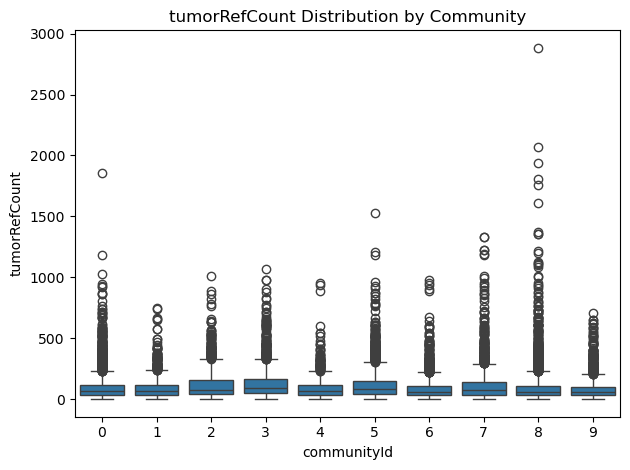

In [23]:
columns_to_analyze = ['tumorAltCount', 'tumorRefCount']
numeric_distribution_by_community(mutation_annotated, columns_to_analyze)

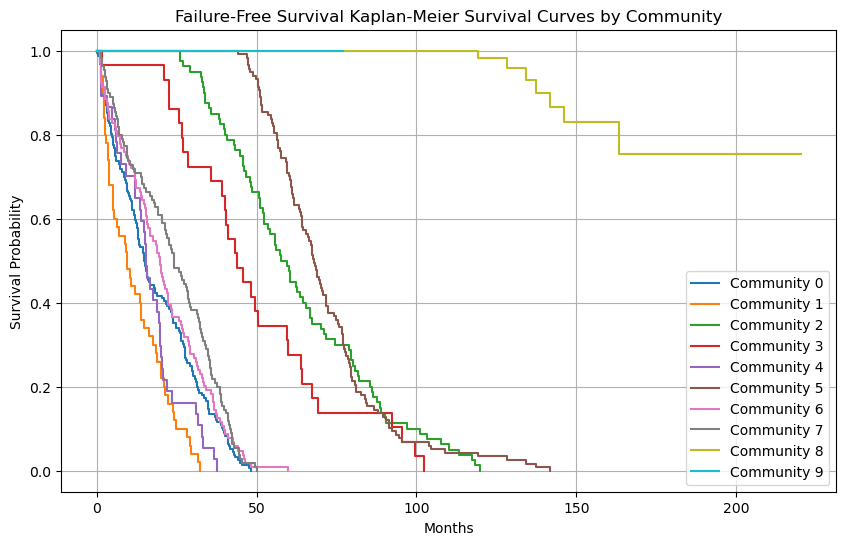

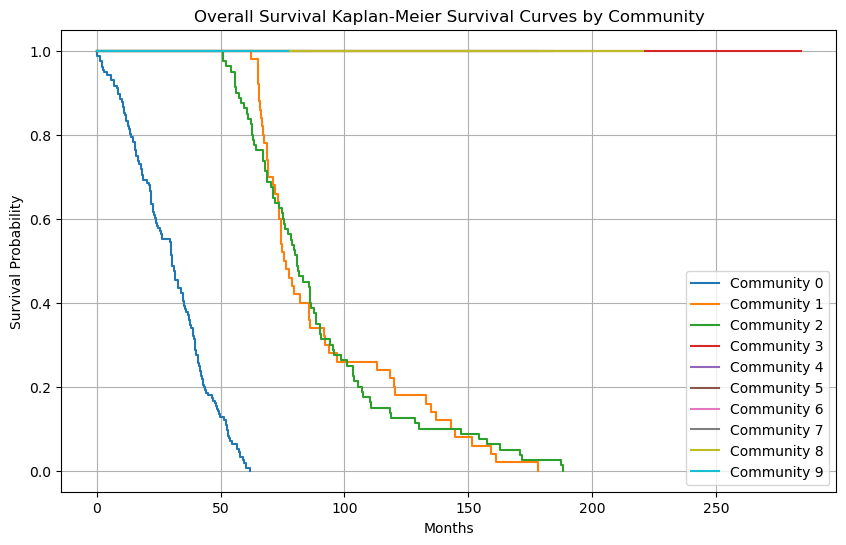

In [24]:
# 📌 SECTION 7: SURVIVAL ANALYSIS
def survival_km(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10,6))
    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col], label=f"Community {name}")
        kmf.plot_survival_function(ci_show=False)
    plt.title(f"{label} Kaplan-Meier Survival Curves by Community")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.show()

# Convert FFS_STATUS and OS_STATUS to binary event columns
# merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
# merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

survival_km(merged_df, 'FFS_MONTHS', 'FFS_STATUS', label='Failure-Free Survival')
survival_km(merged_df, 'OS_MONTHS', 'OS_STATUS', label='Overall Survival')

In [25]:
# 📌 SECTION 8: STATISTICAL TESTS
def run_statistical_tests(df, groupby='communityId'):
    print("\n📊 Kruskal-Wallis Test for AGE_SAMPLING:")
    groups = [group['AGE_SAMPLING'].dropna() for _, group in df.groupby(groupby)]
    print(kruskal(*groups))

    for feat in ['SEX', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE']:
        print(f"\n📊 Chi-square Test for {feat}:")
        contingency = pd.crosstab(df[groupby], df[feat])
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

run_statistical_tests(merged_df)


📊 Kruskal-Wallis Test for AGE_SAMPLING:
KruskalResult(statistic=np.float64(46.061285687073074), pvalue=np.float64(5.86638232373302e-07))

📊 Chi-square Test for SEX:
Chi2 = 27.88, p-value = 0.0010

📊 Chi-square Test for CLL_EPITYPE:
Chi2 = 231.84, p-value = 0.0000

📊 Chi-square Test for TUMOR_MOLECULAR_SUBTYPE:
Chi2 = 16.87, p-value = 0.0508


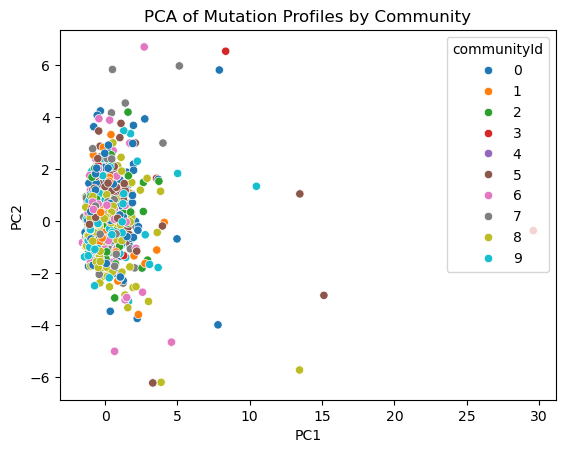

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

# Subset features (e.g., top 50 genes across all patients)
# pivot: patients x genes (1 if mutated, 0 otherwise)
mut = mutation_df.copy()
mut['mut_flag'] = 1
mut_matrix = mut.pivot_table(index='patientId', columns='hugoGeneSymbol', values='mut_flag', fill_value=0)

# Filter top 100 mutated genes
top_genes = mut['hugoGeneSymbol'].value_counts().head(100).index
mut_matrix = mut_matrix[top_genes.intersection(mut_matrix.columns)]

# Merge with community labels
feat_df = pd.merge(mut_matrix.reset_index(), community_df, on='patientId')

# Standardize and reduce
X = StandardScaler().fit_transform(feat_df[top_genes])
pca = PCA(n_components=2).fit_transform(X)
feat_df['PC1'], feat_df['PC2'] = pca[:,0], pca[:,1]

sns.scatterplot(data=feat_df, x='PC1', y='PC2', hue='communityId', palette='tab10')
plt.title("PCA of Mutation Profiles by Community")
plt.show()


In [27]:
# pip install gseapy
import gseapy as gp

gene_list = list(mut_matrix.columns[mut_matrix.sum() > 10])  # example threshold
enr = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2021_Human', outdir=None)
enr.results[['Term', 'Adjusted P-value', 'Overlap']]


,Term,Adjusted P-value,Overlap
0,Thyroid cancer,0.000090,5/37
1,Hepatitis B,0.000090,8/162
2,Bladder cancer,0.000090,5/41
3,Chronic myeloid leukemia,0.000090,6/76
4,Endometrial cancer,0.000337,5/58
...,...,...,...
158,Neutrophil extracellular trap formation,0.629424,1/189
159,Pathogenic Escherichia coli infection,0.641095,1/197
160,Diabetic cardiomyopathy,0.648343,1/203
161,Coronavirus disease,0.693794,1/232


## Visualisation

In [28]:
import networkx as nx

# store the nodeId,communityId csv as nodes.csv in base, algo folder
nodes_df = community_df[['nodeId', 'communityId']].drop_duplicates()
# rename nodeId to Id
nodes_df.rename(columns={'nodeId': 'Id'}, inplace=True)

slpa_map_leiden = {
    0: [0,1,2],
    1: [3,4],
    2: [5,6,7],
    3: [8,9]
}

In [29]:
# --- Resolve duplicate Ids in nodes_df according to SLPA parent-child rules ---
from collections import defaultdict

# Reverse mapping: leiden community -> slpa parent
leiden_to_slpa = {}
for slpa, children in slpa_map_leiden.items():
    for child in children:
        leiden_to_slpa[child] = slpa

# Group by Id, collect all communities for each node
id_to_comms = nodes_df.groupby('Id')['communityId'].apply(list)

resolved_rows = []
for node_id, comms in id_to_comms.items():
    if len(comms) == 1:
        # Only one community, keep as is
        resolved_rows.append({'Id': node_id, 'slpa_parent': leiden_to_slpa[comms[0]], 'leiden_child': comms[0]})
    elif set([1,2]).issubset(set([leiden_to_slpa[c] for c in comms])):
        # Belongs to both SLPA 1 and 2, 1 wins
        child_1 = [c for c in comms if leiden_to_slpa[c] == 1][0]
        resolved_rows.append({'Id': node_id, 'slpa_parent': 1, 'leiden_child': child_1})
    elif set([2,3]).issubset(set([leiden_to_slpa[c] for c in comms])):
        # Belongs to both SLPA 2 and 3, 2 wins
        child_2 = [c for c in comms if leiden_to_slpa[c] == 2][0]
        resolved_rows.append({'Id': node_id, 'slpa_parent': 2, 'leiden_child': child_2})
    else:
        # Default: assign to the first community
        resolved_rows.append({'Id': node_id, 'slpa_parent': leiden_to_slpa[comms[0]], 'leiden_child': comms[0]})

resolved_df = pd.DataFrame(resolved_rows)
# headers should be Id, slpa_parent, communityId
resolved_df.rename(columns={'leiden_child': 'communityId'}, inplace=True)
resolved_df.to_csv(os.path.join(base_path, algo, 'nodes.csv'), index=False)



In [30]:
G = nx.read_gml(os.path.join(base_path, "graph.gml"), label='id')

# store edges as source,targt,weight csv
edges_df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'data'])
edges_df['weight'] = edges_df['data'].apply(lambda x: x.get('weight', 1))  # default weight to 1 if not present
edges_df = edges_df[['source', 'target', 'weight']]  # keep only relevant columns
# save edges to edges.csv in base, algo folder
edges_df.to_csv(os.path.join(base_path, algo, 'edges.csv'), index=False)

In [36]:
# based on this new resolved_df and G, compute newman girvan modularity
from cdlib.evaluation import newman_girvan_modularity
from cdlib import NodeClustering
# Use the resolved_df to get communities
resolved_communities = resolved_df['communityId'].unique()

communities = {cid: set(resolved_df[resolved_df['communityId'] == cid]['Id']) for cid in resolved_communities}
communities_list = list(communities.values())
communities_node_clustering = NodeClustering(communities_list, G, method_name="SLPA_Leiden_Resolved")
modularity = newman_girvan_modularity(G, communities_node_clustering).score
print(f"Newman-Girvan Modularity: {modularity:.4f}")    

Newman-Girvan Modularity: 0.3988
